In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from diffusers import SchedulerMixin, DDPMScheduler
from tqdm import tqdm
from typing import Optional, Tuple, Union


from dataclasses import dataclass
from diffusers.utils import BaseOutput
from diffusers.models.modeling_utils import ModelMixin
from diffusers.models.embeddings import GaussianFourierProjection, TimestepEmbedding, Timesteps
from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.models.unets.unet_1d_blocks import get_down_block, get_mid_block, get_out_block, get_up_block

/mnt/disk1/duanran/anaconda3/envs/py3.8torch2.0/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def data_preloader(data_path):
    """
    Load the data from the data path

    Parameters
    ----------
    data_path: str
        The path of the data

    Returns
    -------
    data: np.ndarray
        The data loaded from the data path

    data_index: np.ndarray
        The index of the data
    """
    comban_data = []
    comban_idx = []
    for dpath in data_path:
        data = np.log1p(np.loadtxt(dpath))
        # data = (data/data.max())*10
        data_index = np.arange(np.shape(data)[0])
        comban_data.append(data)
        comban_idx.append(data_index)
    data = np.concatenate(comban_data, axis=0)
    data_index = np.concatenate(comban_idx, axis=0)
    print(np.shape(data))
    print(np.shape(data_index))
    return data, data_index

def data_preloader_single_celltype():
    comban_data = []
    comban_idx = []
    cell_lines = ['GM12878','K562','HMEC','HUVEC','NHEK']
    for cell_line in cell_lines:
        for chr_num in range(2,3):
            data = np.loadtxt('/mnt/disk1/duanran/data/hic_bulk_data/{0}dense/{1}{2}'.format(cell_line,cell_line,chr_num))
            data = np.log1p(data)
            data = (data/data.max())*10
            data_index = np.arange(np.shape(data)[0])
            comban_data.append(data)
            comban_idx.append(data_index)
    data = np.concatenate(comban_data, axis=0)
    data_index = np.concatenate(comban_idx, axis=0)
    print(np.shape(data))
    print(np.shape(data_index))
    return data, data_index

data, data_index = data_preloader_single_celltype()

(24320, 4864)
(24320,)


In [3]:
class HiCDataset(Dataset):
    def __init__(self, data,rescale=1):
        self.data = data
        # self.indexes = torch.arange(len(data))处以rescale，向下取整
        self.indexes = torch.arange(len(data))//rescale
        print(self.indexes.shape)
        print(self.indexes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.indexes[idx], self.data[idx]

class HiCDataset2(Dataset):
    def __init__(self, data,idx,rescale=1):

        self.data = data
        self.indexes = idx//rescale
        print(self.indexes.shape)
        print(self.indexes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.indexes[idx], self.data[idx]

In [13]:
data_path = ['/mnt/disk1/duanran/data/hic_bulk_data/GM12878dense/GM128782',
                '/mnt/disk1/duanran/data/hic_bulk_data/K562dense/K5622',
                '/mnt/disk1/duanran/data/hic_bulk_data/HMECdense/HMEC2',
                '/mnt/disk1/duanran/data/hic_bulk_data/HUVECdense/HUVEC2',
                '/mnt/disk1/duanran/data/hic_bulk_data/NHEKdense/NHEK2',
             ]
# data, data_index = data_preloader(data_path)

data_size = np.shape(data)[0]
data_length = np.shape(data)[1]
train_data_cutoff = int(data_size*0.8)

train_dataset = HiCDataset2(torch.tensor(data[0:train_data_cutoff,0:data_length], dtype=torch.float32),idx = data_index[0:train_data_cutoff])
test_dataset = HiCDataset2(torch.tensor(data[train_data_cutoff:data_size,0:data_length], dtype=torch.float32),idx = data_index[train_data_cutoff:data_size])
full_dataset = HiCDataset2(torch.tensor(data[0:data_size,0:data_length],dtype=torch.float32), idx= data_index[0:data_size])
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=200, shuffle=True)

(19456,)
[   0    1    2 ... 4861 4862 4863]
(4864,)
[   0    1    2 ... 4861 4862 4863]
(24320,)
[   0    1    2 ... 4861 4862 4863]


In [14]:
# hic_mat = np.loadtxt('/mnt/disk1/duanran/data/hic_bulk_data/GM12878dense/GM128782')
# # hic_mat = np.loadtxt('/mnt/disk1/duanran/data/hic_bulk_data/GM12878_10kb_dense/GM128782')
#
# hic_mat = np.log1p(hic_mat)
# all_hic_mat = (hic_mat/hic_mat.max())*10
#
# print(np.shape(all_hic_mat))
# print(all_hic_mat.max())
#
# data_size = np.shape(all_hic_mat)[0]
# train_data_cutoff = int(0.8*data_size)
#
# train_dataset = HiCDataset(torch.tensor(all_hic_mat[0:train_data_cutoff,0:data_size], dtype=torch.float32))
# test_dataset = HiCDataset(torch.tensor(all_hic_mat[train_data_cutoff:data_size,0:data_size], dtype=torch.float32))
# full_dataset = HiCDataset(torch.tensor(all_hic_mat[0:data_size,0:data_size],dtype=torch.float32), rescale = 20)
# train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=300, shuffle=False)
# full_loader = DataLoader(full_dataset, batch_size=200, shuffle=True)

In [15]:
torch.cuda.set_device(1)
device=torch.device('cuda'  if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [16]:

class Conv1DAutoencoderWithFC(nn.Module):
    def __init__(self, sequence_length):
        super(Conv1DAutoencoderWithFC, self).__init__()

        # 编码器层
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # 解码器层
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.encoderfc = nn.Sequential(
            nn.Linear(4864, 2048),
            nn.ReLU(),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        self.decoderfc = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4864),
            nn.ReLU()
        )

        self.encoderfc2 = nn.Sequential(
            nn.Linear(1520, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.ReLU()
        )
        self.decoderfc2 = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 1520),
            nn.ReLU()
        )

    def forward(self, x):
        # 一维卷积编码
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # 全连接
        # encoded = self.encoderfc(x)
        # decoded = self.decoderfc(encoded)

        # 全连接+一维卷积
        # encoded = self.encoderfc(x)
        # encoded = self.encoder(encoded)
        # decoded = self.decoder(encoded)
        # decoded = self.decoderfc(decoded)

        # 一维卷积——全连接
        # encoded = self.encoder(x)
        # encoded = self.encoderfc2(encoded)
        # decoded = self.decoderfc2(encoded)
        # decoded = self.decoder(decoded)

        return decoded,encoded

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=774, stride=4, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=4, stride=2, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=4, stride=2, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=4, stride=2, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU()
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1),# 输出: [batch_size, 1, 1024]
            nn.ReLU(),
            nn.ConvTranspose1d(16, 32, kernel_size=3, stride=2, padding=1),# 输出: [batch_size, 1, 1024]
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, kernel_size=3, stride=2, padding=1),# 输出: [batch_size, 1, 1024]
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, kernel_size=3, stride=2, padding=1),# 输出: [batch_size, 1, 1024]
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1), # 输出: [batch_size, 1, 1024]
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=834, stride=4, padding=1), # 输出: [batch_size, 1, 1024]
            nn.ReLU()

        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded




In [17]:
# 假设每个输入样本的长度是4000
sequence_length = 4864
print(sequence_length)

# 定义自己的 cosine loss 计算函数
def cosine_loss_fn(y_pre, x):
    similarity = F.cosine_similarity(y_pre, x, dim=2)  # 在每个样本的通道维度上计算
    loss = 1 - similarity.mean()  # 计算平均相似度并转化为损失
    return loss
# 实例化模型
model = Conv1DAutoencoderWithFC(sequence_length=sequence_length).to(device)
# model =  ConvAutoencoder().to(device)

loss_mse=nn.MSELoss(reduction='mean')
loss_bce = nn.BCELoss()
criterion = nn.CosineEmbeddingLoss()
opt=torch.optim.Adam(model.parameters(),lr=0.001)
loss_list = []
for epoch in tqdm(range(1000)):
    model.train()
    for idx, x in train_loader:
        # x 第二个维度加1
        x = x.unsqueeze(1).to(device)
        y_pre,embedding=model(x)
        mse_loss=loss_mse(y_pre,x)
        cosine_loss= cosine_loss_fn(y_pre, x)
        combined_loss = 0.9 * cosine_loss + 0.1 * mse_loss
        # 反向传播和优化
        opt.zero_grad()
        combined_loss.backward()
        opt.step()
        # print('mse_loss:',mse_loss.item(),'cosine_loss:',cosine_loss.item())
        
    # # 每100个epoch绘制一次hic mat
    # if epoch % 100 == 0:
    #     model.eval()
    #     with torch.no_grad():
    #         all_y = []
    #         all_indx = []
    #         for idx, x in test_loader:
    #             x = x.unsqueeze(1).to(device)
    #             y_pre,embedding=model(x)
    #             all_y.append(y_pre.cpu().detach().squeeze(1).numpy())
    #             all_indx.append(idx.numpy())
    #         all_y = np.concatenate(all_y, axis=0)
    #         all_indx = np.concatenate(all_indx, axis=0)
    #         # 按照all_indx排序 all_y
    #         sorted_idx = np.argsort(all_indx)
    #         all_y = all_y[sorted_idx]
    #         sns.heatmap(all_y, cmap='coolwarm',square=True)
    #         plt.show()


    loss_list.append(combined_loss.item())

4864


100%|██████████| 1000/1000 [09:18<00:00,  1.79it/s]


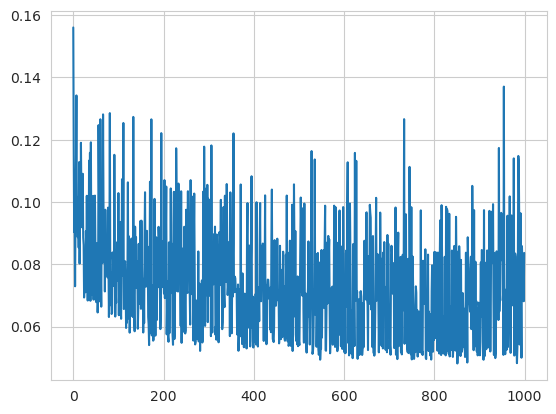

In [18]:
# 绘制loss曲线
plt.plot(loss_list)
plt.show()

In [10]:
class getEmbedding:
    """
    Get the embedding of Hic mat from an autoencoder model

    Parameters
    ----------
    model: nn.Module
        The autoencoder model
    dataloader: DataLoader
        The dataloader of the Hic mat
    """

    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.outputs = []
        self.all_embeddings = []
        self.all_idx = []
        self.input = []
        with torch.no_grad():
            for idx, x in self.dataloader:
                self.input.append(x)
                x = x.unsqueeze(1).to(device)
                y_pre,embedding=model(x)
                self.outputs.append(y_pre.squeeze(1))
                self.all_embeddings.append(embedding)
                self.all_idx.append(idx)
        self.input = torch.cat(self.input, dim=0)
        self.all_embeddings = torch.cat(self.all_embeddings, dim=0)
        self.all_idx = torch.cat(self.all_idx, dim=0)
        self.outputs = torch.cat(self.outputs, dim=0)


    def showHicMat(self,full_mat='center',color_max=4,specific_loc: Optional[int] = [1,2,3,4]):
        """
        Show the Hic mat

        Parameters
        ----------
        full_mat: str
            'full' or 'center' for full mat or center mat
        color_max: int
            The max value of the color bar
        """
        input_hic_mat = self.input.cpu().numpy()
        output_hic_mat = self.outputs.cpu().numpy()
        input_shape = np.shape(input_hic_mat)
        output_shape = np.shape(output_hic_mat)
        sorted_idx = torch.argsort(self.all_idx)
        sorted_input_hic_mat = input_hic_mat[sorted_idx]
        sorted_output_hic_mat = output_hic_mat[sorted_idx]
        # sorted_output_hic_mat 转置相加除2
        # sorted_output_hic_mat = (sorted_output_hic_mat + sorted_output_hic_mat.T)/2

        if full_mat == 'full':
            fig, ax = plt.subplots(1, 2, figsize=(16, 8))
            sns.heatmap(sorted_input_hic_mat , cmap='coolwarm', vmin=0, vmax=color_max, square=True, ax=ax[0])
            sns.heatmap(sorted_output_hic_mat, cmap='coolwarm', vmin=0, vmax=color_max, square=True, ax=ax[1])
        elif full_mat == 'center':
            fig, ax = plt.subplots(1, 2, figsize=(16, 8))
            sns.heatmap(sorted_input_hic_mat[0:input_shape[0],input_shape[1]-input_shape[0]:input_shape[1]], cmap='coolwarm',  vmin=0, vmax=color_max,square=True, ax=ax[0])
            sns.heatmap(sorted_output_hic_mat[0:output_shape[0],output_shape[1]-output_shape[0]:output_shape[1]], cmap='coolwarm',  vmin=0, vmax=color_max,square=True, ax=ax[1])
        elif full_mat =='specific':
            fig, ax = plt.subplots(1, 2, figsize=(16, 8))
            sns.heatmap(sorted_input_hic_mat[specific_loc[0]:specific_loc[1],specific_loc[2]:specific_loc[3]], cmap='coolwarm',  vmin=0, vmax=color_max,square=True, ax=ax[0])
            sns.heatmap(sorted_output_hic_mat[specific_loc[0]:specific_loc[1],specific_loc[2]:specific_loc[3]], cmap='coolwarm',  vmin=0, vmax=color_max,square=True, ax=ax[1])


        plt.show()

    def __call__(self):
        return self.all_embeddings,self.all_idx

In [11]:
Emd = getEmbedding(model, test_loader, device)

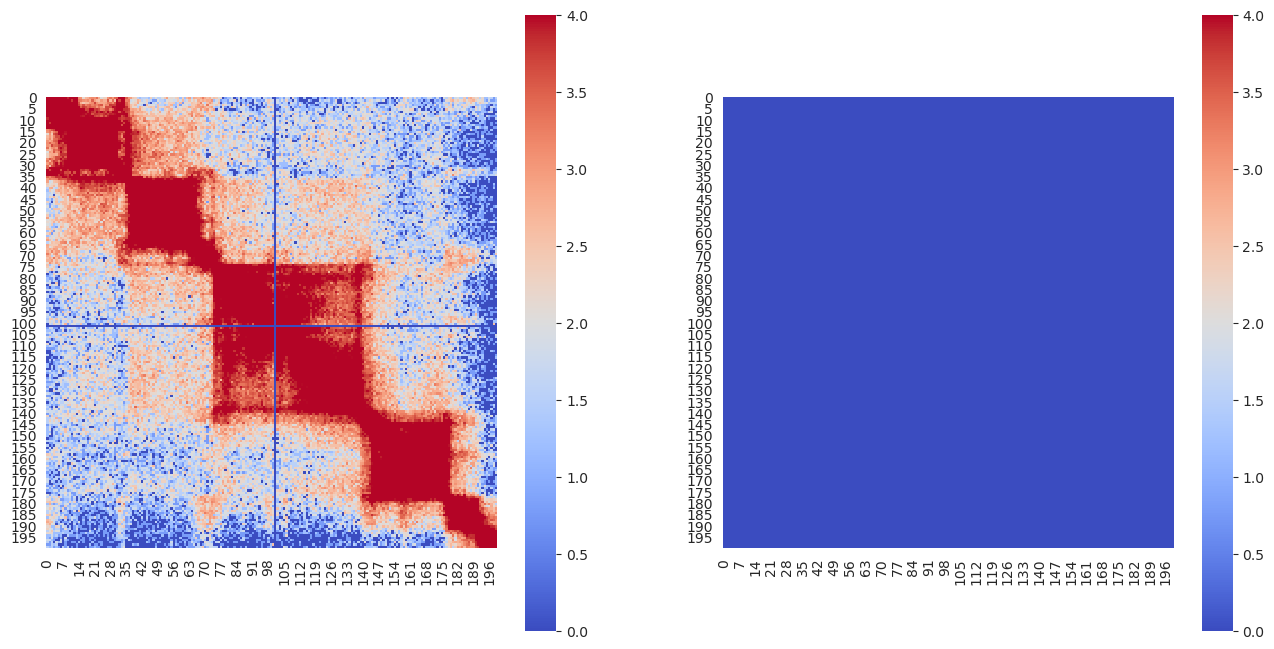

In [12]:
Emd.showHicMat(full_mat='specific',specific_loc=[0,200,0,200])

In [47]:
encode_embedding_gpu,idx = Emd()

In [48]:
encode_embedding = encode_embedding_gpu.cpu().numpy()


In [49]:
type(encode_embedding)
np.shape(encode_embedding)

(4864, 3, 152)

In [50]:
class MinMaxNormalize:
    """
    Minmax normalization for a torch tensor to (-1, 1)

    Parameters
    ----------
    tensor: torch.Tensor
        The tensor to be normalized
    dim: int
        The dimension to be normalized
    """

    def __init__(self, x, dim= 0 ):
        self.dim = dim
        self.min = np.min(x, axis=dim, keepdims=True)
        self.max = np.max(x, axis=dim, keepdims=True)
        print(np.min(self.max - self.min))
        # 一个很小的数字，防止分母为0
        if np.min(self.max - self.min) == 0:
            self.max = self.max + 1e-5
    def normalize(self, x):
        return 2 * (x - self.min) / (self.max - self.min) - 1

    def __call__(self, x):
        return self.normalize(x)

    def denormalize(self, x):
        return (x + 1) / 2 * (self.max - self.min) + self.min

In [51]:
MinMax = MinMaxNormalize(encode_embedding)

nom_ebedding = MinMax(encode_embedding)



1.1512346


In [52]:
rescale = 20
max_index = np.shape(nom_ebedding)[0]
max_spatialencoding = max_index // rescale +1
print(max_spatialencoding)
print(len(idx))
print(nom_ebedding.shape)

244
4864
(4864, 3, 152)


In [53]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, indices):
        """
        初始化数据集
        :param embeddings: 全部embeddings的tensor，形状为[4864, 3, 304]
        :param indices: 对应的索引tensor，形状为[4864]
        """
        self.embeddings = embeddings
        self.indices = indices

    def __len__(self):
        """
        返回数据集中的总样本数
        """
        return len(self.indices)

    def __getitem__(self, idx):
        """
        根据索引idx获取单个样本
        :param idx: 样本的索引
        """
        return  self.indices[idx],self.embeddings[idx]

In [54]:
embedding_dataset = EmbeddingDataset(nom_ebedding , idx)

# 使用DataLoader来创建batch，指定batch size为100
embdding_data_loader = DataLoader(embedding_dataset, batch_size=200, shuffle=True)


In [55]:
class SpatialEncoding(nn.Module):
    """
    Encode spatial information of spots. Similar to the position encoding in transformers.
    :param channels: the dimension of the tensor to apply spatial encoding to.
    :param max_len: the maximum length of the input tensor.
    """

    def __init__(self,
                 channels: int,
                 max_len: int = 1000):
        super(SpatialEncoding, self).__init__()
        self.channels = channels
        self.max_len = max_len
        pos_enc = torch.zeros(1, max_len, channels)
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / \
            torch.pow(10000, torch.arange(0, channels, 2, dtype=torch.float32) / channels)
        pos_enc[:, :, 0::2] = torch.sin(X)
        pos_enc[:, :, 1::2] = torch.cos(X)
        self.register_buffer('pos_enc', pos_enc)


    def forward(self,
                spatial_coord: torch.Tensor):
        """
        :param spatial_coord: spatial coordinates of spots, shape (batch_size, 1)
        :return pos_enc: positional encoding of the input spatial coordinates, shape (batch_size, 1, channels)
        """
        indices = spatial_coord[:, 0].long()  # Convert coordinates to long for indexing
        pos_enc = self.pos_enc[:, indices, :]  # Retrieve positional encoding for each index
        return pos_enc.permute(1, 0, 2)  # Permute to match shape (batch_size, 1, channels)

@dataclass
class UNet1DOutputHic(BaseOutput):
    """
    The output of [`UNet1DModel`].

    Args:
        sample (`torch.FloatTensor` of shape `(batch_size, num_channels, sample_size)`):
            The hidden states output from the last layer of the model.
    """

    sample: torch.FloatTensor
    spatial_coord: torch.Tensor

class UNet1DModelHic(ModelMixin, ConfigMixin):
    r"""
    A 1D UNet model that takes a noisy sample and a timestep and returns a sample shaped output.

    This model inherits from [`ModelMixin`]. Check the superclass documentation for it's generic methods implemented
    for all models (such as downloading or saving).

    Parameters:
        sample_size (`int`, *optional*): Default length of sample. Should be adaptable at runtime.
        in_channels (`int`, *optional*, defaults to 2): Number of channels in the input sample.
        out_channels (`int`, *optional*, defaults to 2): Number of channels in the output.
        extra_in_channels (`int`, *optional*, defaults to 0):
            Number of additional channels to be added to the input of the first down block. Useful for cases where the
            input data has more channels than what the model was initially designed for.
        time_embedding_type (`str`, *optional*, defaults to `"fourier"`): Type of time embedding to use.
        freq_shift (`float`, *optional*, defaults to 0.0): Frequency shift for Fourier time embedding.
        flip_sin_to_cos (`bool`, *optional*, defaults to `False`):
            Whether to flip sin to cos for Fourier time embedding.
        down_block_types (`Tuple[str]`, *optional*, defaults to `("DownBlock1DNoSkip", "DownBlock1D", "AttnDownBlock1D")`):
            Tuple of downsample block types.
        up_block_types (`Tuple[str]`, *optional*, defaults to `("AttnUpBlock1D", "UpBlock1D", "UpBlock1DNoSkip")`):
            Tuple of upsample block types.
        block_out_channels (`Tuple[int]`, *optional*, defaults to `(32, 32, 64)`):
            Tuple of block output channels.
        mid_block_type (`str`, *optional*, defaults to `"UNetMidBlock1D"`): Block type for middle of UNet.
        out_block_type (`str`, *optional*, defaults to `None`): Optional output processing block of UNet.
        act_fn (`str`, *optional*, defaults to `None`): Optional activation function in UNet blocks.
        norm_num_groups (`int`, *optional*, defaults to 8): The number of groups for normalization.
        layers_per_block (`int`, *optional*, defaults to 1): The number of layers per block.
        downsample_each_block (`int`, *optional*, defaults to `False`):
            Experimental feature for using a UNet without upsampling.
    """

    @register_to_config
    def __init__(
            self,
            sample_size: int = 65536,
            sample_rate: Optional[int] = None,
            in_channels: int = 2,
            out_channels: int = 2,
            spatial_encoding: str = "sinusoidal",
            spatial_channels: int = 244,
            extra_in_channels: int = 0,
            time_embedding_type: str = "fourier",
            flip_sin_to_cos: bool = True,
            use_timestep_embedding: bool = False,
            freq_shift: float = 0.0,
            down_block_types: Tuple[str] = ("DownBlock1DNoSkip", "DownBlock1D", "AttnDownBlock1D"),
            up_block_types: Tuple[str] = ("AttnUpBlock1D", "UpBlock1D", "UpBlock1DNoSkip"),
            mid_block_type: Tuple[str] = "UNetMidBlock1D",
            out_block_type: str = None,
            block_out_channels: Tuple[int] = (32, 32, 64),
            act_fn: str = None,
            norm_num_groups: int = 8,
            layers_per_block: int = 1,
            downsample_each_block: bool = False,
    ):
        super().__init__()
        self.sample_size = sample_size
        if spatial_encoding == "sinusoidal":
            self.spa_encoder = SpatialEncoding(sample_size, spatial_channels)

        # time
        if time_embedding_type == "fourier":
            self.time_proj = GaussianFourierProjection(
                embedding_size=8, set_W_to_weight=False, log=False, flip_sin_to_cos=flip_sin_to_cos
            )
            timestep_input_dim = 2 * block_out_channels[0]
        elif time_embedding_type == "positional":
            self.time_proj = Timesteps(
                block_out_channels[0], flip_sin_to_cos=flip_sin_to_cos, downscale_freq_shift=freq_shift
            )
            timestep_input_dim = block_out_channels[0]

        if use_timestep_embedding:
            time_embed_dim = block_out_channels[0] * 4
            self.time_mlp = TimestepEmbedding(
                in_channels=timestep_input_dim,
                time_embed_dim=time_embed_dim,
                act_fn=act_fn,
                out_dim=block_out_channels[0],
            )

        self.down_blocks = nn.ModuleList([])
        self.mid_block = None
        self.up_blocks = nn.ModuleList([])
        self.out_block = None

        # down
        output_channel = in_channels
        for i, down_block_type in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]

            if i == 0:
                input_channel += extra_in_channels

            is_final_block = i == len(block_out_channels) - 1

            down_block = get_down_block(
                down_block_type,
                num_layers=layers_per_block,
                in_channels=input_channel,
                out_channels=output_channel,
                temb_channels=block_out_channels[0],
                add_downsample=not is_final_block or downsample_each_block,
            )
            self.down_blocks.append(down_block)

        # mid
        self.mid_block = get_mid_block(
            mid_block_type,
            in_channels=block_out_channels[-1],
            mid_channels=block_out_channels[-1],
            out_channels=block_out_channels[-1],
            embed_dim=block_out_channels[0],
            num_layers=layers_per_block,
            add_downsample=downsample_each_block,
        )

        # up
        reversed_block_out_channels = list(reversed(block_out_channels))
        output_channel = reversed_block_out_channels[0]
        if out_block_type is None:
            final_upsample_channels = out_channels
        else:
            final_upsample_channels = block_out_channels[0]

        for i, up_block_type in enumerate(up_block_types):
            prev_output_channel = output_channel
            output_channel = (
                reversed_block_out_channels[i + 1] if i < len(up_block_types) - 1 else final_upsample_channels
            )

            is_final_block = i == len(block_out_channels) - 1

            up_block = get_up_block(
                up_block_type,
                num_layers=layers_per_block,
                in_channels=prev_output_channel,
                out_channels=output_channel,
                temb_channels=block_out_channels[0],
                add_upsample=not is_final_block,
            )
            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        # out
        num_groups_out = norm_num_groups if norm_num_groups is not None else min(block_out_channels[0] // 4, 32)
        self.out_block = get_out_block(
            out_block_type=out_block_type,
            num_groups_out=num_groups_out,
            embed_dim=block_out_channels[0],
            out_channels=out_channels,
            act_fn=act_fn,
            fc_dim=block_out_channels[-1] // 4,
        )

    def forward(
            self,
            sample: torch.FloatTensor,
            timestep: Union[torch.Tensor, float, int],
            spatial_coord: torch.FloatTensor = None,
            return_dict: bool = True,
    ) -> Union[UNet1DOutputHic, Tuple]:
        r"""
        The [`UNet1DModel`] forward method.

        Args:
            sample (`torch.FloatTensor`):
                The noisy input tensor with the following shape `(batch_size, num_channels, sample_size)`.
            timestep (`torch.FloatTensor` or `float` or `int`): The number of timesteps to denoise an input.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~models.unet_1d.UNet1DOutput`] instead of a plain tuple.

        Returns:
            [`~models.unet_1d.UNet1DOutput`] or `tuple`:
                If `return_dict` is True, an [`~models.unet_1d.UNet1DOutput`] is returned, otherwise a `tuple` is
                returned where the first element is the sample tensor.
        """

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        timestep_embed = self.time_proj(timesteps)

        if self.config.use_timestep_embedding:
            timestep_embed = self.time_mlp(timestep_embed)
        else:
            timestep_embed = timestep_embed[..., None]
            timestep_embed = timestep_embed.repeat([1, 1, sample.shape[2]]).to(sample.dtype)
            timestep_embed = timestep_embed.broadcast_to((sample.shape[:1] + timestep_embed.shape[1:]))


        # 2. spatial
        spatial_coord = spatial_coord.view(-1,1)
        spatial_embed = self.spa_encoder(spatial_coord)
        emb = spatial_embed + timestep_embed

        # 2. down
        down_block_res_samples = ()
        for downsample_block in self.down_blocks:
            sample, res_samples = downsample_block(hidden_states=sample, temb=emb)
            down_block_res_samples += res_samples

        # 3. mid
        if self.mid_block:
            sample = self.mid_block(sample, emb)

        # 4. up
        for i, upsample_block in enumerate(self.up_blocks):
            res_samples = down_block_res_samples[-1:]
            down_block_res_samples = down_block_res_samples[:-1]
            sample = upsample_block(sample, res_hidden_states_tuple=res_samples, temb=emb)

        # 5. post-process
        if self.out_block:
            sample = self.out_block(sample, emb)

        if not return_dict:
            return (sample,)
        return UNet1DOutputHic(sample=sample, spatial_coord=spatial_coord)


In [56]:
unet_model = UNet1DModelHic(sample_size=152, in_channels=19, out_channels=3,spatial_channels =max_spatialencoding ).to(device)

In [57]:
def train_denoiser(train_loader,
                   model,
                   noise_scheduler: SchedulerMixin,
                   n_epochs: int = 1000,
                   lr: float = 1e-4,
                   lr_scheduler: str = "cosine_annealing",
                   weight_decay: float = 1e-6,
                   gradient_clip: float = 5,
                   num_class_embeds: Optional[int] = None,
                   save_dir: Optional[str] = None,
                   evaluate_interval: Optional[int] = None,
                   model_name: str = "denoiser",
                   device: str = "gpu",
                   check_points=None,
                   eval_fn=None,
                   eval_kwargs=None,
                   ):
    pbar = tqdm(range(n_epochs))
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    if lr_scheduler == "cosine_annealing":
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    else:
        raise NotImplementedError
    loss_list = []
    for epoch in range(1, n_epochs + 1):
        for batch_idx, tdata in enumerate(train_loader):
            batch = tdata[1].to(device)
            loaction = tdata[0].to(device)
            loaction = loaction // rescale
            clean_data = batch
            clean_data = clean_data  # (batch_size, 1, num_channels)
            optimizer.zero_grad()
            noise = torch.randn_like(clean_data)
            timesteps = torch.randint(0, 1000, (clean_data.shape[0],), device=device, dtype=torch.long)
            noisy_data = noise_scheduler.add_noise(clean_data, noise, timesteps)
            noise_pred = model(noisy_data, timesteps,loaction).sample
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            loss_list.append(loss.item())
            # clip gradient
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
            optimizer.step()
            pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}, batch_id: {batch_idx}")
        lr_scheduler.step()

        # # 每100个epoch绘制一次hic mat
        # if epoch % 100 == 0:
        #     model.eval()
        #     with torch.no_grad():
        #         all_y = []
        #         all_indx = []
        #         for idx, x in test_loader:
        #             x = x.unsqueeze(1).to(device)
        #             y_pre,embedding=model(x)
        #             all_y.append(y_pre.cpu().detach().squeeze(1).numpy())
        #             all_indx.append(idx.numpy())
        #         all_y = np.concatenate(all_y, axis=0)
        #         all_indx = np.concatenate(all_indx, axis=0)
        #         # 按照all_indx排序 all_y
        #         sorted_idx = np.argsort(all_indx)
        #         all_y = all_y[sorted_idx]
        #         sns.heatmap(all_y, cmap='coolwarm',square=True)
        #         plt.show()


    return model, loss_list

In [58]:
deff_model, loss_list = train_denoiser(embdding_data_loader, unet_model, noise_scheduler=DDPMScheduler(), n_epochs=1000, lr=1e-4, lr_scheduler="cosine_annealing", weight_decay=1e-6, gradient_clip=5, device=device)

Epoch: 1000, Loss: 0.0071, batch_id: 24:   0%|          | 0/1000 [21:55<?, ?it/s]


In [59]:
deff_model

UNet1DModelHic(
  (spa_encoder): SpatialEncoding()
  (time_proj): GaussianFourierProjection()
  (down_blocks): ModuleList(
    (0): DownBlock1DNoSkip(
      (resnets): ModuleList(
        (0): ResConvBlock(
          (conv_skip): Conv1d(19, 32, kernel_size=(1,), stride=(1,), bias=False)
          (conv_1): Conv1d(19, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (group_norm_1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (gelu_1): GELU(approximate='none')
          (conv_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (group_norm_2): GroupNorm(1, 32, eps=1e-05, affine=True)
          (gelu_2): GELU(approximate='none')
        )
        (1-2): 2 x ResConvBlock(
          (conv_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (group_norm_1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (gelu_1): GELU(approximate='none')
          (conv_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (gr

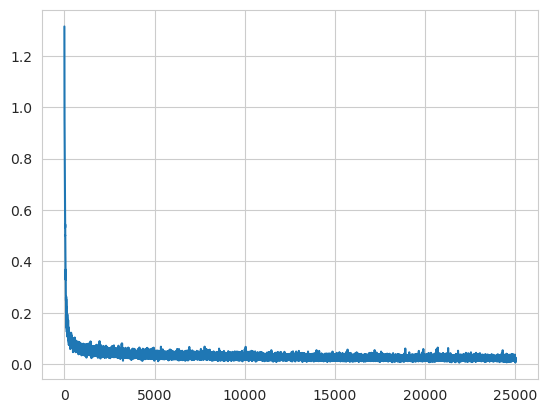

In [60]:
# 绘制loss_list
plt.plot(loss_list)
plt.show()

In [67]:
import itertools
all_sim_embed = []
all_idx = []
all_loaction = []
with torch.no_grad():
    for idxx,tdata in enumerate(embdding_data_loader):
        gen_indx = tdata[0].to(device)
        location = gen_indx // rescale
        sim_embed = torch.randn_like(tdata[1]).to(device)
        print(sim_embed.shape)

        noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
        iterator = noise_scheduler.timesteps

        for t in iterator:
            model_output = deff_model(sim_embed, t,location).sample
            sim_embed = noise_scheduler.step(model_output, t, sim_embed).prev_sample
        all_sim_embed.append(sim_embed.cpu().detach().numpy())
        all_idx.append(gen_indx.cpu().detach().numpy())
        all_loaction.append(location.cpu().detach().numpy())

torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([200, 3, 152])
torch.Size([64, 3, 152])


In [68]:
all_gen_embed = []
final_index = []
for emb_group, idx_group in zip(all_sim_embed , all_idx):
    emb_group = MinMax.denormalize(emb_group)
    emb_group = torch.tensor(emb_group, dtype=torch.float32).to(device)
    emb_group = model.decoder(emb_group)
    emb_group = emb_group.cpu().detach().numpy()
    all_gen_embed.append(emb_group)
    final_index.append(idx_group)


In [69]:
final_mat = []
final_i = []
for emb_group, idx_group in zip(all_gen_embed, final_index):
    emb_group2 = emb_group.squeeze(1)
    for single_v in emb_group2:
        final_mat.append(single_v)
    for single_i in idx_group:
        final_i.append(single_i)


In [70]:
final_mat = np.array(final_mat)
final_i = np.array(final_i)

In [71]:
# 按照final_i排序final_mat，numpy语法
sorted_idx = np.argsort(final_i)
sorted_final_mat = final_mat[sorted_idx]


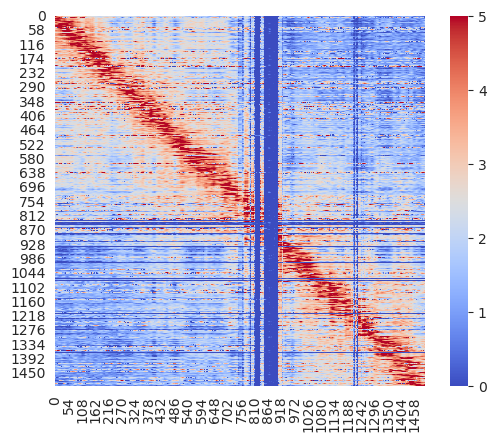

In [367]:
map_begin = 0
map_end = 100
color_max = 4
sns.heatmap(sorted_final_mat[1000:2500,1000:2500], vmin=0,vmax= 5,cmap='coolwarm', square=True)
plt.show()

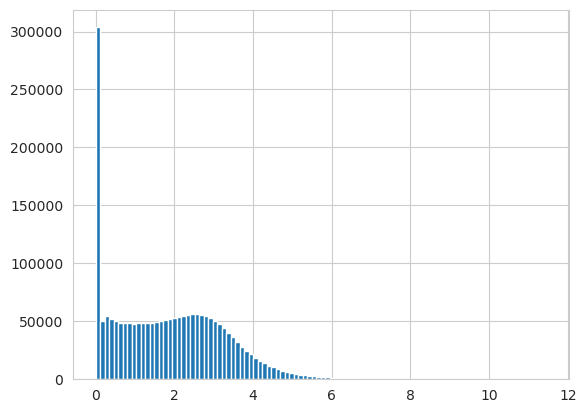

In [92]:
# sorted_final_mat 数值分布
plt.hist(sorted_final_mat.flatten(), bins=100)
plt.show()

In [197]:
# 只要前100个
noise = noise[0:100]
noise.shape

torch.Size([100, 3, 304])

In [198]:
# noise加在到gpu上
noise = noise.to(device)

In [93]:
# sim_embed to numpy
sim_embed = sim_embed.cpu().detach().numpy()

In [95]:
sim_embed.shape

(100, 3, 304)

In [97]:
sim_embed = MinMax.denormalize(sim_embed)

In [99]:
# sim_embed to torch
sim_embed = torch.tensor(sim_embed, dtype=torch.float32).to(device)

In [100]:
# 调用model的decoder
gen = model.decoder(sim_embed)

In [101]:
# gen to cpu
gen = gen.cpu()
# gen to numpy
gen = gen.detach().numpy()


In [102]:
# gen 去掉中间的维度
gen = gen.squeeze(1)

In [103]:
np.shape(gen)

(100, 4864)

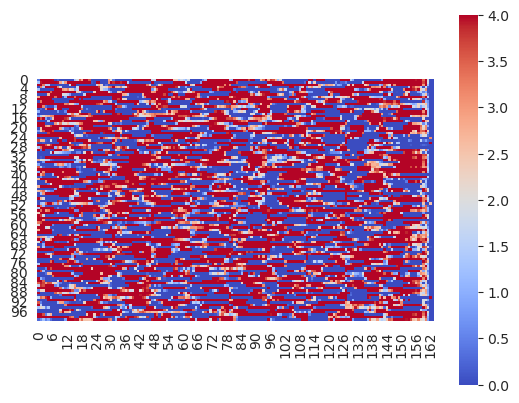

In [105]:
map_begin = 0
map_end = 100
color_max = 4
sns.heatmap(gen[0:100,4700:4864], cmap='coolwarm', vmin=0, vmax=color_max, square=True)
plt.show()

In [26]:
import torch
import math

def positional_encoding(pos, model_dim):
    """ Generate sinusoidal positional encodings for the given batch of positions """
    pe = torch.zeros(pos, model_dim)
    position = torch.arange(0, pos, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, model_dim, 2).float() * -(math.log(10000.0) / model_dim))

    pe[:, 0::2] = torch.sin(position * div_term)  # Apply sine to even indices in the tensor
    pe[:, 1::2] = torch.cos(position * div_term)  # Apply cosine to odd indices

    return pe

pos_encoding = positional_encoding(4864, 304)  # Example: 50 positions, 512 dimensions
print(pos_encoding)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.0827e-01,  ...,  1.0000e+00,
          1.0625e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.5184e-01,  ...,  1.0000e+00,
          2.1249e-04,  1.0000e+00],
        ...,
        [-8.1699e-01, -5.7666e-01,  8.6157e-01,  ...,  8.5319e-01,
          4.9381e-01,  8.6957e-01],
        [-9.2666e-01,  3.7590e-01,  9.1753e-01,  ...,  8.5313e-01,
          4.9390e-01,  8.6952e-01],
        [-1.8437e-01,  9.8286e-01,  2.1911e-01,  ...,  8.5307e-01,
          4.9399e-01,  8.6946e-01]])


In [27]:
pos_encoding.shape

torch.Size([4864, 304])

In [241]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=774, stride=4, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size=4, stride=2, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=4, stride=2, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=4, stride=2, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=4, stride=2, padding=1),  # 输出: [batch_size, 16, 512]
            nn.ReLU(),
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 16, kernel_size=3, stride=2, padding=1),# 输出: [batch_size, 1, 1024]
            nn.ReLU(),
            nn.ConvTranspose1d(16, 32, kernel_size=3, stride=2, padding=1),# 输出: [batch_size, 1, 1024]
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1),# 输出: [batch_size, 1, 1024]
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, kernel_size=3, stride=2, padding=1), # 输出: [batch_size, 1, 1024]
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=834, stride=4, padding=1), # 输出: [batch_size, 1, 1024]
            nn.ReLU()

        )

    def forward(self, x):
        x = self.encoder(x)
        print(x.shape)
        x = self.decoder(x)
        return x

# 创建模型和测试输入
model = ConvAutoencoder()
input_vector = torch.randn(10, 1, 4864)  # 假设batch size为10

# 前向传播
output = model(input_vector)
print(output.shape)

torch.Size([10, 1, 64])
torch.Size([10, 1, 4864])
